In [1]:
import spacy
import numpy
numpy.random.seed(42)
from keras.preprocessing import sequence
from itertools import cycle
import pandas
from ast import literal_eval

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
text = 'shareholder seemed to lose interest in the project to restructure MoryGlobal and its durability'

In [5]:
nlp = spacy.load('en_vectors_web_lg')

OSError: Can't find model 'en_vectors_web_lg'

In [4]:
doc = nlp(text)

In [8]:
doc[-4].vector

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [71]:
df = pandas.read_csv('training_set.csv')

In [280]:
small_df = df.sample(100)

In [281]:
small_df.to_csv('sample_training_set.csv', index=False)

In [28]:
texts = [literal_eval(inp) for inp in df.x]

In [29]:
_, full_texts = zip(*texts)

In [72]:
labels = df.y.values

In [73]:
TOP_WORDS_STEMMED = ['insolven', 'bankrupt', 'liquidat', 'restructur', 'administration']

In [74]:
from collections import namedtuple

def text_to_input(nlp, text, key_words):
    processed_text = nlp(text)
    tokens = [w.lex_id for w in processed_text if (w.is_stop is False and str(w).isalnum())]
    key_word_features = [sum([w.lemma_.startswith(key_word) for w in processed_text]) for key_word in key_words]
    return tokens, key_word_features

def word_to_vector(nlp, word):
    try:
        return nlp.vocab.vectors.data[word]
    except IndexError:
        return None

def sentence_to_vectors(nlp, sentence):
    word_vectors = [word_to_vector(nlp, word) for word in sentence]
    return [word_vector for word_vector in word_vectors if isinstance(word_vector, numpy.ndarray)]

def sentences_to_vectors(nlp, sentences):
    return [sentence_to_vectors(nlp, sentence) for sentence in sentences]

def texts_to_inputs(nlp, texts, key_words):
    return [text_to_input(nlp, text, key_words) for text in texts]

def get_batch_ids(ids, batch_size):
    n_batches = len(ids) // batch_size
    indices = [
        slice(i * batch_size, (i + 1) * batch_size)
        for i in range(n_batches)
    ]
    if len(ids) % batch_size:  # if list cannot be split equally, the remainder is yielded
        indices += [slice(n_batches * batch_size, len(ids))]
    return indices

def process_single_batch(nlp, batch, max_len):
    word_vectors, key_word_features = zip(*batch)
    word_vectors = sentences_to_vectors(nlp, word_vectors)
    word_vectors = sequence.pad_sequences(word_vectors, maxlen=max_len, dtype='float32')
    key_word_features = numpy.array(key_word_features)
    return word_vectors, key_word_features

def get_data_generator(nlp, inputs, labels, batch_size, max_len):
    indices = get_batch_ids(range(len(inputs)), batch_size)
    n_batches = len(indices)
    
    def batch_generator():
        for batch_indices in cycle(indices):
            batch_inputs = inputs[batch_indices]
            batch_labels = labels[batch_indices]
            word_vectors, key_word_features = process_single_batch(nlp, batch_inputs, max_len)
            yield [word_vectors, key_word_features], numpy.array(batch_labels)
            
    return n_batches, batch_generator()

def inputs_to_str(inputs):
    return [[[str(x) for x in input[i]] for i in range(2)] for input in inputs]

def str_to_output(input_str):
    return " ".join(input_str[0]) + "," + " ".join(input_str[1])

def save_inputs_to_file(inputs, output_file_path):
    inputs_str = inputs_to_str(inputs)
    with open(output_file_path, 'w') as output_file:
        for text in inputs_str:
            output_file.write(str_to_output(text) + '\n')
            
def get_inputs_from_file(input_file_path):
    with open(input_file_path, 'r') as input_file:
        cleaned_texts = input_file.readlines()
    cleaned_texts = [cleaned_text.split(",") for cleaned_text in cleaned_texts]
    cleaned_texts = [(text.split(), top_words.split()) for text, top_words in cleaned_texts]
    cleaned_texts = [[[int(el) for el in column] for column in row] for row in cleaned_texts]
    return cleaned_texts

In [9]:
import time
t1 = time.time()
inputs = texts_to_inputs(nlp, full_texts, TOP_WORDS_STEMMED)
print('Full texts preparation took {} minutes'.format((time.time() - t1) / 60))

Full texts preparation took 23.343753623962403 minutes


In [ ]:
save_inputs_to_file(inputs, 'cleaned_training_texts.txt')

In [75]:
retreived_inputs = get_inputs_from_file('cleaned_training_texts.txt')

In [65]:
def remove_frequent_rare_words(sentence, threshold_low, threshold_high):
    return [word for word in sentence if threshold_low < word < threshold_high]

In [76]:
len(retreived_inputs)

13432

In [77]:
import random

In [195]:
short_inputs = [[remove_frequent_rare_words(retreived_input[0], 100, 10000), retreived_input[1]] for retreived_input in retreived_inputs]

In [78]:
inputs_len = len(retreived_inputs)
test_size = 0.2
test_size = int(test_size * inputs_len)
test_indices = random.sample(range(inputs_len), test_size)
train_indices = [i for i in range(inputs_len) if i not in test_indices]
X_test, labels_test = zip(*[(retreived_inputs[i], labels[i]) for i in test_indices])
X_train, labels_train = zip(*[(retreived_inputs[i], labels[i]) for i in train_indices])
n_train_batches, train_generator = get_data_generator(nlp, X_train, labels_train, batch_size=128, max_len=400)
n_test_batches, test_generator = get_data_generator(nlp, X_test, labels_test, batch_size=128, max_len=400)

In [79]:
from keras.layers import Dense, Conv1D, BatchNormalization, GlobalMaxPooling1D, \
    Activation, Dropout, MaxPooling1D, Input, concatenate
from keras.models import Model
from keras.regularizers import l2

def build_conv1d(max_len=1000, embedding_dim=300, filters=32, kernel_size=5, l2_weight=0.001,
                 dropout_rate=0.7, additional_features_dim=5):

    net_input = Input(shape=(None, embedding_dim))
    conv1 = Conv1D(
        filters, kernel_size, strides=1, kernel_regularizer=l2(l2_weight),
        input_shape=(max_len, embedding_dim), padding='valid', activation='relu')(net_input)
    conv1 = MaxPooling1D(5)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv1D(
        2 * filters, kernel_size, strides=1, kernel_regularizer=l2(l2_weight),
        input_shape=(max_len, embedding_dim), padding='valid', activation='relu')(conv1)
    net_output = GlobalMaxPooling1D()(conv2)
    logit_input = Input(shape=(additional_features_dim,))
    merged_inputs = concatenate([net_output, logit_input])
    fcn = BatchNormalization()(merged_inputs)
    fcn = Dropout(0.7)(fcn)
    fcn = Dense(1, kernel_regularizer=l2(l2_weight))(fcn)
    fcn = Activation("sigmoid")(fcn)  # Te linijke musisz wyebac
    model = Model([net_input, logit_input], fcn)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Tu musisz zmienic loss na 'mse'
    return model

In [240]:
model = build_conv1d()

In [80]:
from keras.models import model_from_json

In [ ]:
save_path = 'spacy_embedding_conv1d'
config = model.to_json()
with open(save_path + '.json', 'w') as outfile:
    json.dump(config, outfile)
conv1d.save_weights(save_path + '.hdf5')

In [81]:
import json

In [83]:
with open('spacy_embedding_conv1d.json') as json_data:
    config = json.load(json_data)

In [84]:
model = model_from_json(config)

In [85]:
model.load_weights('spacy_embedding_conv1d.hdf5')

In [241]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, 300)    0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, None, 32)     48032       input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, None, 32)     0           conv1d_9[0][0]                   
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, None, 32)     128         max_pooling1d_5[0][0]            
__________________________________________________________________________________________________
conv1d_10 

In [247]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=n_train_batches,
                              epochs=7,
                              verbose=1,
                              validation_data=test_generator,
                              validation_steps=n_test_batches)

Epoch 1/7
84/84 [==============================] - 31s 370ms/step - loss: 0.8655 - acc: 0.6845 - val_loss: 0.3543 - val_acc: 0.9133
Epoch 2/7
84/84 [==============================] - 32s 376ms/step - loss: 0.4331 - acc: 0.8900 - val_loss: 0.2936 - val_acc: 0.9136
Epoch 3/7
84/84 [==============================] - 30s 355ms/step - loss: 0.3230 - acc: 0.9401 - val_loss: 0.2473 - val_acc: 0.9345
Epoch 4/7
84/84 [==============================] - 30s 356ms/step - loss: 0.2508 - acc: 0.9620 - val_loss: 0.2031 - val_acc: 0.9557
Epoch 5/7
84/84 [==============================] - 30s 361ms/step - loss: 0.2052 - acc: 0.9724 - val_loss: 0.1829 - val_acc: 0.9702
Epoch 6/7
84/84 [==============================] - 29s 347ms/step - loss: 0.1794 - acc: 0.9776 - val_loss: 0.1856 - val_acc: 0.9691
Epoch 7/7
84/84 [==============================] - 30s 355ms/step - loss: 0.1607 - acc: 0.9833 - val_loss: 0.1873 - val_acc: 0.9687


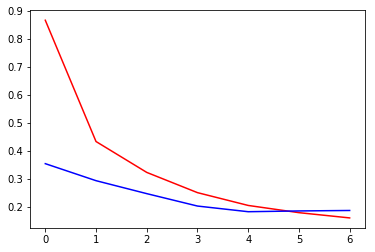

In [248]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], c='red')
_ = plt.plot(history.history['val_loss'], c='blue')

In [86]:
def get_predictions_labels(model, generator, n_batches):
    predictions = []
    labels = []
    for _ in range(n_batches):
        X, y = next(generator)
        predictions += list(model.predict(X)[:, 0])
        labels += list(y)
    return predictions, labels

In [87]:
train_predictions, train_labels = get_predictions_labels(model, train_generator, n_train_batches)

In [88]:
test_predictions, test_labels = get_predictions_labels(model, test_generator, n_test_batches)

In [89]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_labels, train_predictions)

0.99832869001806923

In [90]:
roc_auc_score(test_labels, test_predictions)

0.9973381777626753

In [91]:
from sklearn.metrics import roc_curve

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt

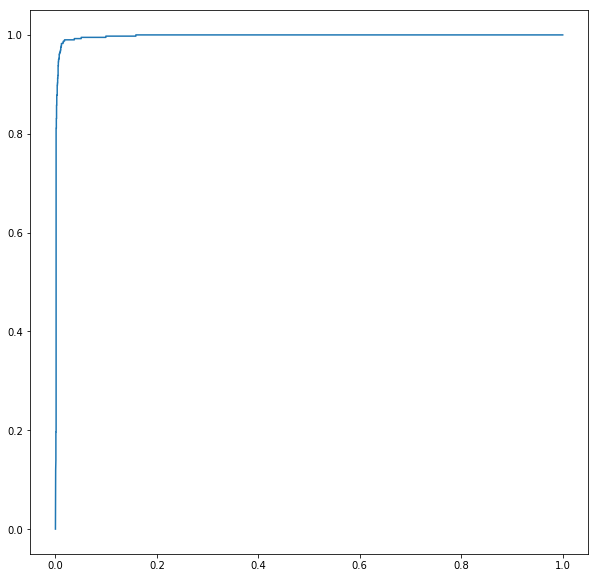

In [94]:
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
plt.figure(figsize=(10, 10))
_ = plt.plot(fpr, tpr)

In [276]:
import json

In [278]:
save_path = 'spacy_embedding_conv1d'
config = model.to_json()
with open(save_path + '.json', 'w') as outfile:
    json.dump(config, outfile)
model.save_weights(save_path + '.hdf5')

In [186]:
short_inputs = [[remove_frequent_rare_words(retreived_input[0], 100, 10000), retreived_input[1]] for retreived_input in retreived_inputs]

In [253]:
from sklearn.metrics import roc_curve

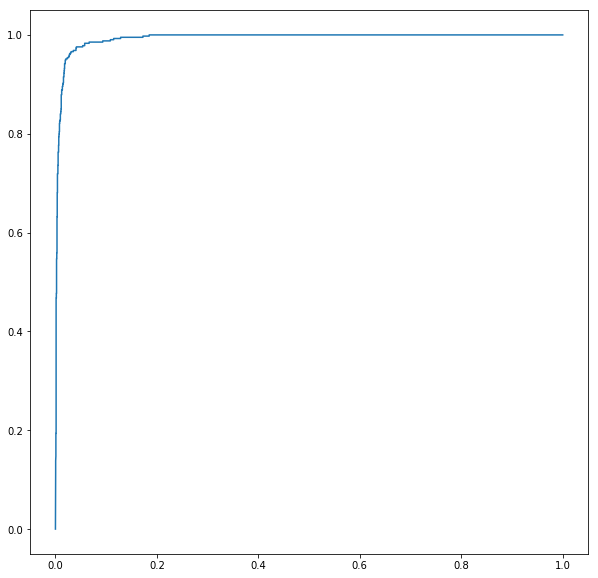

In [256]:
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
plt.figure(figsize=(10, 10))
_ = plt.plot(fpr, tpr)

In [257]:
from sklearn.metrics import precision_recall_curve

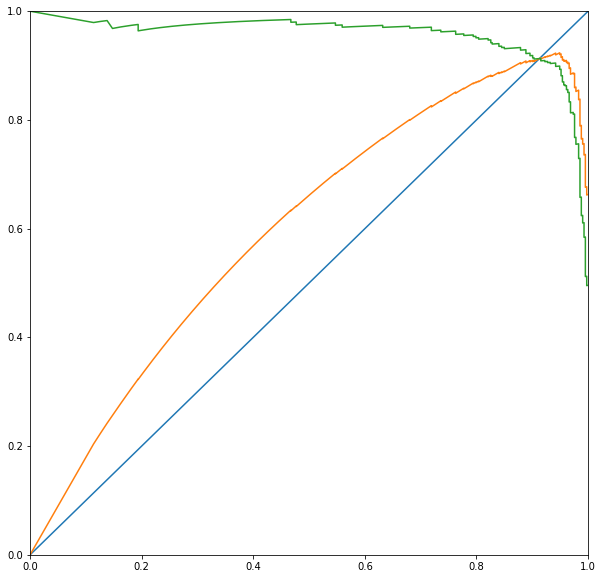

In [273]:
pr, rec, tresh = precision_recall_curve(test_labels, test_predictions)
plt.figure(figsize=(10, 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1])
f1s = 2 / (1 / numpy.clip(pr, 1e-6, None) + 1 / numpy.clip(rec, 1e-6, None))
plt.plot(rec, f1s)
_ = plt.plot(rec, pr)

In [263]:
tresh[numpy.abs(pr - rec).argmin()]

0.25652885

In [264]:
print(pr[numpy.abs(pr - rec).argmin()], rec[numpy.abs(pr - rec).argmin()])

0.912832929782 0.912832929782


In [274]:
tresh[f1s.argmax()]

0.14560272

In [275]:
print(f1s[f1s.argmax()], pr[f1s.argmax()], rec[f1s.argmax()])

0.9234393404 0.899082568807 0.949152542373


In [187]:
article_lengths = [len(retreived_input[0]) for retreived_input in short_inputs]

In [188]:
numpy.percentile(article_lengths, q=[85, 90, 95, 99])

array([ 275.,  328.,  423.,  753.])

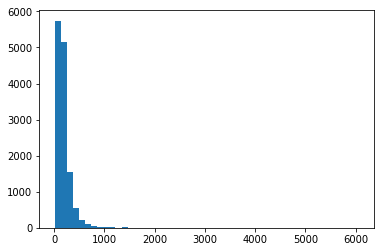

In [189]:
_ = plt.hist(article_lengths, bins=50)

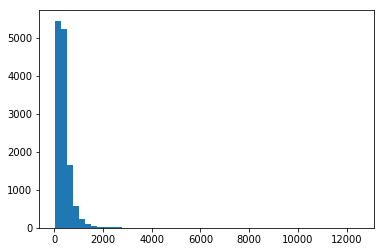

In [37]:
_ = plt.hist([len(retreived_input[0]) for retreived_input in retreived_inputs], bins=50)

In [ ]:
n_batches

In [ ]:
labels

In [ ]:
for net_input, batch_labels in generator:
    print(net_input, batch_labels)
    break

In [ ]:
import tensorflow as tf
with tf.gfile.GFile('french_feeds.csv', mode="r") as data_file:
    x = data_file.readlines()

In [ ]:
x[0].split()

In [ ]:
import pandas

In [ ]:
l = [[1,2,3,4], [2,3,4]]

In [ ]:
l =  [1]

In [ ]:
l = [(1, 2), (3, 4), (5, 6)]

In [ ]:
x, y = [1, 2]

In [ ]:
y

In [ ]:
for x, y in product(range(2), range(1)):
    print(x, y)

In [ ]:
x, y = zip(*l)

In [ ]:
x_span = [1,2,3]
y_span = [4,5,6]

In [ ]:
from itertools import product
for x, y in product(x_span, y_span):
    print(x, y)

In [ ]:
df = pandas.read_csv('signal_feeds_201705a.csv', encoding='latin-1')

In [ ]:
df = df[df.Language.isin(['France', 'French'])][['Domain']]

In [ ]:
df = df.drop_duplicates(subset='Domain')

In [ ]:
df.to_csv('french_feeds.csv', index=False)

In [ ]:
pandas.read_csv('french_feeds.csv').head()

In [ ]:
df.Language.value_counts()

In [ ]:
df = pandas.read_csv('records_languages.csv')

In [ ]:
df = df[df.language_y.isin(['en', 'de', 'fr', 'es', 'it', 'nl'])]

In [ ]:
df = df[df.approved.isin([0.0, 1.0])]

In [ ]:
import re
import string
import numpy
import spacy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def clean(nlp, text):
    regex = " *[%s]+ *" % string.punctuation.replace("\\", "\\\\").replace("]", "\\]")
    text = re.sub(regex, " ", text)
    doc = nlp(text)
    doc = [w for w in doc if (w.is_stop is False and str(w).isalnum())]
    return numpy.mean([w.vector for w in doc], axis=0)

def prepare_dataset(df, language_code, embedding_dim):
    nlp = spacy.load(language_code)
    df_lang = df[df.language_y == language_code[:2]]
    n_rows = df_lang.shape[0]
    X = numpy.zeros(shape=(n_rows, embedding_dim))
    y = numpy.zeros(shape=(n_rows,))
    for i, (_, row) in enumerate(df_lang.iterrows()):
        X[i] = clean(nlp, row.text_y)
        y[i] = row.approved
    return X, y

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
text = """Donald Trump has heaped praise on his administration’s response to Hurricane Maria, said Puerto Rico’s leaders should be “very proud” of the low official death toll – and appeared to complain at the cost of the recovery effort.

The US president’s remarks came on his first visit to the US territory since it was pummeled by a category 4 hurricane nearly two weeks ago, amid continuing criticism that his government has failed to adequately respond to the crisis.


Life or death as Puerto Rico's older people go without essentials
 Read more
The island’s 3.4 million residents – particularly those in the more isolated parts – are still largely without electricity, communications and access to clean drinking water and food."""

In [ ]:
doc = nlp(text)

In [ ]:
type(doc)

In [ ]:
cleaned_doc = [w for w in doc if (w.is_stop is False and str(w).isalnum())]

In [ ]:
type(cleaned_doc[0])

In [ ]:
len(cleaned_doc)

In [ ]:
help(spacy.vectors.Vectors.find)

In [ ]:
spacy.vectors.Vectors(1)

In [ ]:
spacy.language.Language.

In [ ]:
type(nlp.vocab.vectors.values())

In [ ]:
nlp.vocab.vectors.data.shape

In [ ]:
numpy.allclose(nlp.vocab.vectors.data[doc[0].lex_id], doc[0].vector)

In [ ]:
dir(nlp.vocab.vectors)

In [ ]:
dir(nlp.vocab)

In [ ]:
dir(nlp)

In [ ]:
help(spacy.load)

In [ ]:
dir(spacy.language.Language)

In [ ]:
help(spacy.language.Language.__call__)

In [ ]:
help(spacy.lang.en.English)

In [ ]:
doc = nlp('')

In [ ]:
nlp

In [ ]:
dir(spacy.vectors.Vectors)

In [ ]:
spacy.vectors.Vectors.find(doc[0].lex_id)

In [ ]:
doc[0].vector

In [ ]:
doc[0].lex_id

In [ ]:
dir(doc[0])

In [ ]:
import time
n = 1000
t1 = time.time()
for _ in range(n):
    doc = nlp(text)
    [w.vector for w in doc if (w.is_stop is False and str(w).isalnum())]
time_elapsed = time.time() - t1
print(time_elapsed / n)

In [ ]:
dir(cleaned_doc[0])

In [ ]:
cleaned_doc[0].vector

In [ ]:
embedding_dims = {
    'en_core_web_sm': 384,
    'en_core_web_md': 300,
    'en_core_web_lg': 300,
    'de_core_news_sm': 384,
    'fr_core_news_sm': 384,
    'fr_core_news_md': 300,
    'es_core_news_sm': 384,
    'es_core_news_md': 50,
    'it_core_news_sm': 384,
    'nl_core_news_sm': 384
}

for language_code in embedding_dims:
    X, y = prepare_dataset(df, language_code, embedding_dims[language_code])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    score_train = model.predict_proba(X_train)[:, 1]
    score_test = model.predict_proba(X_test)[:, 1]
    print('Language code: {0}. Number of train records: {1}. Number of test records: {2}'
          .format(language_code, y_train.shape[0], y_test.shape[0]))
    print('Train AUC:', roc_auc_score(y_train, score_train),
          'Test AUC:', roc_auc_score(y_test, score_test))

In [ ]:
embedding_dims = {
    'en_core_web_sm': 384,
    'en_core_web_md': 300,
    'en_core_web_lg': 300,
    'de_core_news_sm': 384,
    'fr_core_news_sm': 384,
    'fr_core_news_md': 300,
    'es_core_news_sm': 384,
    'es_core_news_md': 50,
    'it_core_news_sm': 384,
    'nl_core_news_sm': 384
}

In [ ]:
def lemmatize(nlp, text):
    regex = " *[%s]+ *" % string.punctuation.replace("\\", "\\\\").replace("]", "\\]")
    text = re.sub(regex, " ", text)
    doc = nlp(text)
    doc = [str(w.lemma_).lower() for w in doc if (w.is_stop is False and str(w).isalnum())]
    return ' '.join(doc)

In [ ]:
for language_code in embedding_dims:
    nlp = spacy.load(language_code)
    df_lang = df[df.language_y == language_code[:2]]
    text = df_lang.sample(1).text_y.values[0][:200]
    print('\n\nSample text in {}:\n\n'.format(language_code[:2]), text, end='')
    print('\n\nLemmatized text processed with {}:\n\n'.format(language_code), lemmatize(nlp, text))

In [ ]:
sample_text = df.text_y[df.language_y == 'de'][0]

In [ ]:
len(sample_text.split())

In [ ]:
sample_doc = nlp_de(sample_text)
sample_doc.vector.shape

In [ ]:
sample_text.split()[:10]

In [ ]:
len([x for x in sample_doc if str(x).isalnum()])

In [ ]:
len(sample_doc)

In [ ]:
sample_doc.vector[1]

In [ ]:
for text in df.text_y[df.language_y == 'de']:
    print('\n\nraw text:\n\n', text, '\n\nprocessed text:\n\n', clean(nlp_de, text))
    break

In [ ]:
with open('tokenized_titles/train', 'r') as train_file:
    train = train_file.readlines()

In [ ]:
lengths = [len(title.split()) for title in train]

In [ ]:
_ = plt.hist(lengths, bins=50)

In [ ]:
[int(thres) for thres in numpy.percentile(lengths, [25, 50, 75, 99])]

In [ ]:
sum([l == 0 for l in lengths])

In [ ]:
df = pandas.read_csv('raw-data.csv', encoding='latin-1')

In [ ]:
df.head()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

_ = plt.hist(lengths, bins=50)

In [ ]:
raw_lengths = [
    len(title)
    for title in X.title
    if isinstance(title, str)
]

In [ ]:
sum([el > 180 for el in raw_lengths]) / len(raw_lengths)

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('en')

In [ ]:
doc = nlp(X.text[0])

In [ ]:
clean_doc = [w for w in doc if (w.is_stop is False and str(w).isalnum() and len(str(w)) > 2)]

In [ ]:
' '.join([w.lemma_ for w in clean_doc])

In [ ]:
clean_doc[0]

In [ ]:
clean_doc[0].text

In [ ]:
dir(clean_doc[0])

In [ ]:
_ = plt.hist(raw_lengths, bins=100)

In [ ]:
x = numpy.array([1,2,3])

In [ ]:
numpy.zeros(shape=(1, 3))

In [ ]:
numpy.array([numpy.array([]), x])

In [ ]:
numpy.array(3 * [x])

In [ ]:
import numpy
l = [(1,2), (3,4), (5,6)]

In [ ]:
numpy.array(l).dtype

In [ ]:
l = [list(el) for el in l]

In [ ]:
x, y = zip(*l)

In [ ]:
x

In [ ]:
X = pandas.read_csv('records_28-09-2017_12_17_57.csv')

In [ ]:
for x in X.itertuples():
    print(x['id'])
    break

In [ ]:
poorly_preprocessed = [
    (article.text, article.preprocessed_text,
     article.language, article.translated_text)
    for _, article in X.iterrows()
    if isinstance(article.text, float)
    and i < 10
]

In [ ]:
len(poorly_preprocessed) / X.shape[0]

In [ ]:
l = zip(*poorly_preprocessed)

In [ ]:
l = list(l)
l = l[:2] + [l[-1]]

In [ ]:
len(l)

In [ ]:
l[0][0] == x1[0]

In [ ]:
x1[0]

In [ ]:
x1

In [ ]:
[el1 == el2 for el1, el2 in zip(x1 ,l[0])]

In [ ]:
all([isinstance(x, float)
     for x in x3])

In [ ]:
[for art in poorly_preprocessed
 if all([isinstance(x, float) for x in ])]

In [ ]:
X.shape

In [ ]:
for x in X['text']:
    try:
        x.replace("", "")
    except AttributeError:
        print(isinstance(x, float), isinstance(x, str))
        break

In [ ]:
def translate_title(article):
    article

In [ ]:
preprocessed_titles = [
    row.title if row.language == 'en' 
    else row.translated_title
    for index, row in X.iterrows()
]

In [ ]:
preprocessed_titles[:2]

In [ ]:
X.columns

In [ ]:
X['preprocessed_title'] = pandas.Series(preprocessed_titles, index=X.index)

In [ ]:
preprocessed_titles[:10]

In [ ]:
import pickle

In [ ]:
with open('false_negativesLogitGridF2017-10-27-12:08.pickle', 'rb') as handle:
    false_negatives = pickle.load(handle)

In [ ]:
with open('false_positivesLogitGridF2017-10-27-12:08.pickle', 'rb') as handle:
    false_positives = pickle.load(handle)

In [ ]:
len(false_negatives)

In [ ]:
scores, uncertainties, texts = zip(*false_negatives + false_positives)

In [ ]:
plt.scatter(uncertainties, scores)

In [ ]:
texts[:10]

false_negatives:
    cookies, nontranslated, ad, accident
    all correct

In [ ]:
import pandas

In [ ]:
df = pandas.read_csv('records_28-09-2017_12_17_57.csv')

In [ ]:
df = df[df.provided_approved == 'f']

In [ ]:
df.head()

In [ ]:
false_positives = list()

In [ ]:
for i, row in df.iterrows():
    if row.preprocessed_text in texts[-10:]:
        false_positives.append((row.text, row.preprocessed_text))

In [ ]:
len(false_positives)

In [ ]:
false_positives:
    0 - na figz 1
    1 - na figz 1
    2 - na figz 1
    3 - chyba 1, ale nie rozumiem xD
    4 - na figz 1
    5 - na figz 1
    6 - na figz 1
    7 - sprawa historyczna - jakis pracownik opowiada szczegoly jak firma wpadla w klopoty i czyja to byla wina
    8 - sprawa w sadzie - ktos odpowiada za umyslne spowodowanie bankructwa firmy
    9 - na figz 1

In [ ]:
false_positives[0]

In [ ]:
texts[5]

In [ ]:
texts[-10:]

In [ ]:
false_negatives = list()
for i, row in df.iterrows():
    if row.preprocessed_text in texts[:10]:
        false_negatives.append((row.text, row.preprocessed_text))

In [ ]:
[0, 1, 2] - cookies
[3, 5] - ad
[4] - bad scrape
[6, 7, 9] - ???
[8] - translation problems

In [ ]:
texts[7]

In [ ]:
len(false_negatives)

In [ ]:
false_negatives[4]

In [ ]:
x = list(range(10))
y = list(reversed(range(10)))

In [ ]:
zipped = zip(x, y)

In [ ]:
sorted_x, sorted_y = zip(sorted(zipped, key=lambda x: x[1]))

In [ ]:
sorted_x, sorted_y = zip(*sorted(zipped, key=lambda z: z[1]))

In [ ]:
sorted_y

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pickle

In [ ]:
with open('scores_50_predictionsLogitGridF2017-10-25-13:42.pickle', 'rb') as handle:
    scores = pickle.load(handle)

In [ ]:
with open('uncertainties_50_predictionsLogitGridF2017-10-25-13:42.pickle', 'rb') as handle:
    uncertainties = pickle.load(handle)

In [ ]:
with open('scores_50_predictionsLogitGridF2017-10-25-12:25.pickle', 'rb') as handle:
    scores_std = pickle.load(handle)

In [ ]:
with open('uncertainties_50_predictionsLogitGridF2017-10-25-12:25.pickle', 'rb') as handle:
    uncertainties_std = pickle.load(handle)

In [ ]:
labels = numpy.array([1] * 400 + [0] * 10000, dtype='int32')

In [ ]:
colors = ['red' if label == 1
          else 'blue'
          for label in labels]
zeros_weight = numpy.mean(labels)
ones_weight = 1 - zeros_weight
alphas = [ones_weight if label == 1
          else zeros_weight
          for label in labels]
color_dict = {
    'red': [1, 0, 0],
    'blue': [0, 0, 1]
}
colors = [
    color_dict[color] + [alpha]
    for color, alpha in zip(colors, alphas)
]

In [ ]:
scores = numpy.array(scores)
scores = numpy.clip(scores, 1e-5, 1 - 1e-5)
scores = numpy.log(scores / (1 - scores))

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.title('Network\'s uncertainty measured with BALD measure')
plt.xlabel('Uncertainty')
plt.ylabel('Log odds')
plt.scatter(uncertainties, scores, s=1., c=colors)
plt.subplot(1, 2, 2)
plt.title('Network\'s uncertainty measured with Standard Deviation')
plt.xlabel('Uncertainty')
plt.ylabel('Log odds')
plt.scatter(uncertainties_std, scores_std, s=1., c=colors)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def rescale(x, x_min, x_max):
    scaled_x = (x - numpy.min(x)) / (numpy.max(x) - numpy.min(x))
    return x_max - (x_max - x_min) * scaled_x

In [ ]:
x = numpy.random.normal(size=(100,))

In [ ]:
rescale((1,2,3), 0, 1)

In [ ]:
x[numpy.argmax(x)]

In [ ]:
x[numpy.argmin(x)]

In [ ]:
rescale(x, 5, 6)[numpy.argmax(x)]

In [ ]:
_ = plt.hist(rescale(x, 5, 6))

In [ ]:
scores.shape

In [ ]:
def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))

In [ ]:
numpy.min(sigmoid(scores))

In [ ]:
sigmoid()

In [ ]:
plt.figure(figsize=(10, 10))
_ = plt.scatter(uncertainties_std, scores_std, s=rescale(uncertainties, 0.1, 10.), c=colors)

In [ ]:
sum(numpy.abs(scores) > 4.5)

In [ ]:
sum(numpy.array(uncertainties) < 0.01)

In [ ]:
roc_auc_score(labels, scores)

In [ ]:
roc_auc_score(labels[numpy.array(uncertainties) < 0.01], scores[numpy.array(uncertainties) < 0.01])

In [ ]:
roc_auc_score(labels[numpy.abs(scores) > 4.5], scores[numpy.abs(scores) > 4.5])

In [ ]:
sum(numpy.abs(scores_std) > 6.)

In [ ]:
scores_std = numpy.array(scores_std)

In [ ]:
sum(numpy.array(uncertainties_std) < 1.53)

In [ ]:
roc_auc_score(labels[numpy.abs(scores_std) > 6.], scores_std[numpy.abs(scores_std) > 6.])

In [ ]:
roc_auc_score(labels[numpy.array(uncertainties_std) < 1.53], scores_std[numpy.array(uncertainties_std) < 1.53])

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, _ = roc_curve(labels, scores)
plt.plot(fpr, tpr, c='blue')
_ = plt.plot([0, 1], [0, 1], c='red')

In [ ]:
numpy.log(1e-5 / (1 - 1e-5))

In [ ]:
def sigmoid(x):
    result = numpy.exp(x)
    return result / (1 + result)

In [ ]:
def log_odds(x):
    return numpy.log(x / (1 - x))

In [ ]:
uniform_scores = numpy.random.uniform(-14, 14, size=(10400, 50))

In [ ]:
def variational(x, n):
    return numpy.clip(numpy.random.normal(x, 0.01, size=(n,)), 1e-6, 1 - 1e-6)

In [ ]:
uniform_probs = numpy.random.uniform(size=(10400, 1))
uniform_probs = numpy.apply_along_axis(lambda x: variational(x, 50), 1, uniform_probs)

In [ ]:
def entropy(predictions):
    return - (predictions * numpy.log(predictions) + (1 - predictions) * numpy.log(1 - predictions))

def BALD(predictions):
    return entropy(numpy.mean(predictions, axis=0)) - numpy.mean(entropy(predictions), axis=0)

In [ ]:
uniform_uncertainties_std = numpy.apply_along_axis(numpy.std, 1, uniform_probs)

In [ ]:
uniform_uncertainties_BALD = numpy.apply_along_axis(BALD, 1, uniform_probs)

In [ ]:
uniform_scores = numpy.mean(log_odds(uniform_probs), axis=1)

In [ ]:
_ = plt.scatter(uniform_uncertainties, uniform_scores, c='red', s=1., alpha=0.1)

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.title('Network\'s uncertainty measured with BALD measure')
plt.xlabel('Uncertainty')
plt.ylabel('Log odds')
plt.scatter(uniform_uncertainties_BALD, uniform_scores, s=1., c='red', alpha=0.1)
plt.subplot(1, 2, 2)
plt.title('Network\'s uncertainty measured with Standard Deviation')
plt.xlabel('Uncertainty')
plt.ylabel('Log odds')
plt.scatter(uniform_uncertainties_std, uniform_scores, s=1., c='red', alpha=0.1)
plt.show()

In [ ]:
numpy.max(random_scores)

In [ ]:
X = numpy.zeros(shape=(1, 2))

In [ ]:
numpy.tile(X, (10, 1, 1)).shape

In [ ]:
duplicate_input(X, 10).shape

In [ ]:
X = numpy.random.normal(size=(100, 1))

In [ ]:
X = numpy.exp(X)
X = X / (1 + X)

In [ ]:
numpy.std(X, axis=0)[0]

In [ ]:
numpy.mean(X, axis=0)

In [ ]:
def entropy(predictions):
    return - (predictions * numpy.log(predictions) + (1 - predictions) * numpy.log(1 - predictions))
def BALD(predictions):
    return entropy(numpy.mean(predictions, axis=0)) - numpy.mean(entropy(predictions), axis=0)

In [ ]:
numpy.std(X, axis=0)[0]

In [ ]:
BALD(X)[0]

In [ ]:
numpy.tile(X, (10, 1, 1, 1)).shape

In [ ]:
def duplicate_input(x, n_duplicates):
    return numpy.tile(x, (n_duplicates,) + tuple([1] * (x.ndim - 1)))

In [ ]:
numpy.zeros(shape=(10,))

In [ ]:
def f(x):
    return numpy.zeros(shape=(x.shape[0], 1))

In [ ]:
X = numpy.array([[1,2,3], [4,5,6]])
f(X)

In [ ]:
X = numpy.array([[1,2,3]])

In [ ]:
numpy.array([f(X) for i in range(5)])

In [ ]:
numpy.mean(f(numpy.tile(X, (5, 1))), axis=0)

In [ ]:
colors = tuple([tuple(l) for l in colors])

In [ ]:
with open('scores.pickle', 'wb') as handle:
    pickle.dump(colors, handle)

In [ ]:
X = numpy.array([[1,2,3]])

In [ ]:
X

In [ ]:
numpy.tile(X, (3, 1))

In [ ]:
with open('scores.pickle', 'rb') as handle:
    colors = pickle.load(handle)

In [ ]:
colors = ['red' if el > 0 else 'blue' for el in x]

In [ ]:
alphas = numpy.random.uniform(size=(len(colors),))

In [ ]:
color_dict = {
    'red': [1, 0, 0],
    'blue': [0, 0, 1]
}

In [ ]:
help(plt.scatter)

In [ ]:
colors = [color_dict[color] + [alpha] for color, alpha in zip(colors, alphas)]

In [ ]:
sizes = list(numpy.exp(y))

In [ ]:
x = numpy.linspace(start=-2.0, stop=1.0, num=100)
y = x ** 2 - 1

In [ ]:
labels = numpy.array(x > 0., dtype='int32')

In [ ]:
labels

In [ ]:
zeros_weight = numpy.mean(labels)
ones_weight = 1 - zeros_weight
alphas = [ones_weight if label == 1
          else zeros_weight
          for label in labels]

In [ ]:
numpy.mean(labels)

In [ ]:
plt.scatter(x, y, s=sizes, c=colors)

In [ ]:
str(None) + 'afdads'

In [ ]:
x = (1, 2)

In [ ]:
l = [1,2,3]

In [ ]:
[[] for _ in l]

In [ ]:
[[]] * len(l)

In [ ]:
class A(object):
    def __init__(self):
        self.a = 5
        self._b = 6

In [ ]:
class B(A):
    def __init__(self):
        super(B, self).__init__()

In [ ]:
el1 = A()

In [ ]:
el1._b

In [ ]:
el2 = B()

In [ ]:
el2._b

In [ ]:
from keras.preprocessing import sequence

In [ ]:
import numpy

In [ ]:
X = numpy.random.normal(size=(1, 10))

In [ ]:
X

In [ ]:
sequence.pad_sequences(X, maxlen=14, dtype='float32')

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense

In [ ]:
def receptive_field(x):
    return (x - 4) // 2 - 4

In [ ]:
receptive_field(14)

In [ ]:
model = Sequential()
model.add(Conv1D(40, 5, input_shape = (14, 2)))
model.add(MaxPooling1D(2))
model.add(Conv1D(10, 5))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
model.summary()

In [ ]:
k = 'fsdfsd dsfsdfds dsfdsf dsfdsfsdf ds'

In [ ]:
sorted([
    len(w) for w in k.split()
])[:4]

In [ ]:
l = [(1,2,3), (4,5,6)]

In [ ]:
x, y, z = zip(*l)

In [ ]:
z

In [ ]:
(1, *(1, 5))

In [ ]:
float('nan')

In [ ]:
import tensorflow as tf
import numpy
import random

In [ ]:
numpy.exp(1., dtype='float64')

In [ ]:
logits = numpy.random.normal(size=(1, 10))

In [ ]:
logits

In [ ]:
def multinomial_sampling(logits):
    probs = softmax(logits)
    thresholds = numpy.cumsum(probs)
    x = random.random()
    for i, threshold in enumerate(thresholds):
        if threshold >= x:
            return i

In [ ]:
softmax(logits)

In [ ]:
multinomial_sampling(logits)

In [ ]:
help(numpy.exp)

In [ ]:
numpy.array([1,2.5], dtype='float32')

In [ ]:
help(numpy.random.uniform)

In [ ]:
for i in range(10000):
    X = numpy.random.uniform(-8.5, 8.5, size=(1, 1000))
    numpy.random.multinomial(1, softmax(probs)[0])

In [ ]:
numpy.max(X)

In [ ]:
numpy.min(X)

In [ ]:
from scipy.misc import logsumexp
def log_softmax(vec):
    return vec - logsumexp(vec)


def softmax(vec):
    return numpy.exp(log_softmax(vec))

In [ ]:
probs = softmax(X)

In [ ]:
tf.multinomial(X, 1)

In [ ]:
numpy.random.multinomial(1, probs[0])

In [ ]:
from keras.models import Model
from keras.layers import Input, concatenate, Dense, BatchNormalization, Dropout

inputs_1 = Input(shape=(2,))
inputs_2 = Input(shape=(4,))

dense_1 = Dense(5, activation='relu')(inputs_1)
dense_2 = Dense(5, activation='relu')(inputs_2)
merged = concatenate([dense_1, dense_2])
merged = BatchNormalization()(merged)
dense = Dense(10, activation='sigmoid')(merged)
dense = BatchNormalization()(dense)
dense = Dense(10, activation='sigmoid')(dense)
dense = Dense(10, activation='sigmoid')(dense)
dense = BatchNormalization()(dense)
dense = Dense(1)(dense)
model = Model([inputs_1, inputs_2], dense)
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
batch_norm_layers = [i for i, layer in enumerate(model.layers) if layer.name.startswith('batch_normalization')]

In [ ]:
import keras.backend as K

In [ ]:
import numpy

In [ ]:
batch_norm_indeces, batch_norm_layers = zip(*[(i, layer) for i, layer in enumerate(model.layers) if layer.name.startswith('batch_normalization')])

In [ ]:
model.summary()

In [ ]:
model.layers[-3](model.layers[-4].output)

In [ ]:
model.layers[2].output

In [ ]:
new_model = Model(model.input, model.layers[2].output)
for i, layer in enumerate(model.layers):
    if i > 2:
        print(i, layer)
        new_model = Model(new_model.input, layer(new_model.output))

In [ ]:
new_model = Model(model.input, batch_norm_layers[0].input)
batch_norm = BatchNormalization()(new_model.output)
model.layer[batch_norm_indeces[0] + 1](batch_norm)
new_model = Model(new_model.input, batch_norm)
new_model.layers[-1].set_weights(batch_norm_layers[0].get_weights())

for i, layer in enumerate(batch_norm_layers[1:]):
    new_model = Model(new_model.input, model.layers[batch_norm_indeces[i + 1] - 1](new_model.output))
    batch_norm = BatchNormalization()(new_model.output)
    new_model = Model(new_model.input, batch_norm)
    new_model.layers[-1].set_weights(layer.get_weights())
new_model = Model(new_model.input, model.layers[-1](new_model.output))

In [ ]:
new_model.summary()

In [ ]:
new_model.layers[-1].inbound_nodes = [new_model.layers[-3]]

In [ ]:
new_model.summary()

In [ ]:
new_model.input

In [ ]:
dir(new_model)

In [ ]:
new_model.layers[-2].get_config()

In [ ]:
new_model.get_input_at(0)

In [ ]:
new_model.predict([])

In [ ]:
import keras

In [ ]:
isinstance(new_model.layers[-1], keras.layers.BatchNormalization)

In [ ]:
second_model = model

In [ ]:
merged

In [ ]:
second_model.layers[-3].output

In [ ]:
second_model.layers[-2]._get_node_attribute_at_index()

In [ ]:
second_model.layers[-2]._node_key()

In [ ]:
second_model.layers[-1].inbound_nodes

In [ ]:
second_model.layers[-2].get_config()

In [ ]:
dir(second_model.layers[-1])

In [ ]:
model.layers[-2].momentum

In [ ]:
model.layers[-2].non_trainable_weights

In [ ]:
model.summary()

In [ ]:
model.layers[-1](model.layers[-3].output)

In [ ]:
dir(model.layers[-1])

In [ ]:
'sad'.startswith('fdsa')

In [ ]:
for layer in model.layers:
    if layer.name.startswith('batch_normalization'):
        print(layer.name)

In [ ]:
X1 = numpy.random.normal(size=(10, 2))
X2 = numpy.random.normal(size=(10, 4))

In [ ]:
model.predict([X1, X2])

In [ ]:
model.input

In [ ]:
import keras.backend as K
def variational_inference(model, X, n_times):
    predictor = K.function(model.input + [K.learning_phase()], [model.output])
    results = [predictor(X + [1])[0] for _ in range(n_times)]
    results = numpy.array(results)
    return numpy.mean(results, axis=0), numpy.std(results, axis=0)

In [ ]:
variational_inference(model, [X1, X2], 10)

In [ ]:
d = {
    'a': [1,2],
    'b': [4,5,6]
}

In [ ]:
str(d)

In [ ]:
repr(d)

In [ ]:
from itertools import product

In [ ]:
for x in product(d['a'], d['b']):
    print(x)

In [ ]:
for l in [[(key, el) for el in d[key]] for key in d]:
    print(l)

In [ ]:
for x in product(*[[(key, el) for el in d[key]] for key in d]):
    print(dict(x))
    print(str(dict(x)))
    print("\n\n\n")
    print(' '.join([param[0] + ': ' + str(param[1]) for param in x]))

In [ ]:
for x in product(zip(*d)):
    print(x)

In [ ]:
for x in product(*d.items()):
    print(x)

In [ ]:
import numpy

In [ ]:
X = 5 * numpy.random.normal(size=(1, 1000))

In [ ]:
X = numpy.exp(X)
X / numpy.sum(X, axis=1, keepdims=True)

In [ ]:
int(numpy.argmax(X, axis=1))

In [ ]:
def samples_from_logits(logits):
    probs = numpy.exp(logits)
    probs = probs / numpy.sum(probs, axis=1, keepdims=True)
    samples = [numpy.random.multinomial(1, prob) for prob in probs]
    samples = numpy.argmax(samples, axis=1)
    return samples

In [ ]:
int(samples_from_logits(X))

In [ ]:
numpy.random.multinomial(1, [0.005, 0.99, 0.005])

In [ ]:
help(numpy.random.logseries)

In [ ]:
help(numpy.random.multinomial)

In [ ]:
lengths = []
with open('tokenized/train', 'rb') as f1, open('tokenized/test', 'rb') as f2:
    l1 = [len(l[:-1].decode('utf-8').split()) for l in f1.readlines()]
    l2 = [len(l[:-1].decode('utf-8').split()) for l in f2.readlines()]
    lengths = l1 + l2

In [ ]:
len(lengths)

In [ ]:
lengths[0]

In [ ]:
l1

In [ ]:
l2

In [ ]:
import numpy

In [ ]:
numpy.percentile(lengths, numpy.linspace(start=0, stop=95, num=11))

In [ ]:
sum([el > 400 for el in lengths]) / len(lengths)

In [ ]:
sum([el < 60 for el in lengths]) / len(lengths)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

_ = plt.hist([el for el in lengths if el < 530], bins=50)

In [ ]:
import random

In [ ]:
random.random()

In [ ]:
kupa = 'no jest {t}o jakies cwiczenie'

In [ ]:
import re
re.compile('{|}').sub('', kupa)

In [ ]:
_BREAK_SYMBOLS = b"([ .,!?\"':;)(])"

In [ ]:
_WORD_SPLIT = re.compile(_BREAK_SYMBOLS)

In [ ]:
kupa = b'Advanced technologies and biology have extremely different physical implementations, but they are far more alike in systems-level organization than is widely appreciated. {C}onvergent evolution in both domains produces modular architectures that are composed of elaborate hierarchies of protocols and layers of feedback regulation, are driven by demand for robustness to uncertain environments, and use often imprecise components. {T}his complexity may be largely hidden in idealized laboratory settings and in normal operation, becoming conspicuous only when contributing to rare cascading failures. {T}hese puzzling and paradoxical features are neither accidental nor artificial, but derive from a deep and necessary interplay between complexity and robustness, modularity, feedback, and fragility. {T}his review describes insights from engineering theory and practice that can shed some light on biological complexity.'

In [ ]:
tokens = _WORD_SPLIT.split(kupa)

In [ ]:
tokens

In [ ]:
tokens = [token for token in tokens if token not in _BREAK_SYMBOLS ]

In [ ]:
10 > None

In [ ]:
with open('movie_titles.txt', 'rb') as f:
    for line in f.readlines():
        line = str(line).split(',')
        title = ','.join(line[2:])
        title = title[:-3]
        print(title)

In [ ]:
pandas.readx

In [ ]:
import pandas
df = pandas.read_csv('movie_titles.txt')

In [ ]:
numpy.concatenate(l)

In [ ]:
import numpy
l = [[1,2,3], [1,2]]
numpy.max([numpy.max(x) for x in l])
numpy.min([numpy.min(x) for x in l])

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda, Input, Embedding, SimpleRNN
import tensorflow as tf
import keras.backend as K
input_layer = Input(shape=(20,))
embedding = Embedding(output_dim=10, input_length=20, input_dim=100)
embedding_layer = embedding(input_layer)
dense = SimpleRNN(100)(embedding_layer)
sample = Lambda(lambda x: tf.multinomial(x, 1), output_shape=lambda s: (s[0], 1))(dense)
output_layer = Lambda(lambda x: K.gather(embedding.embeddings,
                                         x[:, 0]),
                      output_shape=lambda s: (s[0], 10))(sample)
output_sample = Lambda(lambda x: K.cast(x, 'float32'))(sample)
model = Model(input_layer, [output_sample, output_layer])
# print(K.max())
model.compile(loss='mae', optimizer='adam')

In [ ]:
model.summary()

In [ ]:
from functools import reduce

In [ ]:
weights = {
    i: 1 for i in range(1, 10)
}

In [ ]:
weights

In [ ]:
weights

In [ ]:
weights[0] = 0

In [ ]:
def f(x, y):
    print(x)
    return x + y
reduce(f, [1,2,3])

In [ ]:
lambda x: x+1

In [ ]:
import numpy

In [ ]:
X = numpy.random.binomial(size=1000, n=100, p=0.1).reshape((50, 20))

In [ ]:
X = numpy.random.binomial(size=100, n=100, p=0.1).reshape((5, 20))
ind, emb = model.predict(X)
ind

In [ ]:
y = numpy.array([[0, 5, 2], [0, 0, 9]])

In [ ]:
X = numpy.random.normal(size=(2, 3, 10))
X = numpy.exp(X)
X = X / numpy.sum(X, axis=-1, keepdims=True)

In [ ]:
y[y > 0]

In [ ]:
numpy.softmax(X)

In [ ]:
ind

In [ ]:
emb

In [ ]:
import pandas

In [ ]:
assert 1 == 0, 'guwno'

In [ ]:
kupa = records.preprocessed_text[records.preprocessed_text.notnull()]

In [ ]:
for k in kupa:
    print(isinstance(k, float))
    break

In [ ]:
kupa = [(1,2), (3,4)]
for i, (ind, dat) in enumerate(kupa):
    print(i)
    print(ind)
    print(dat)

In [ ]:
records = pandas.DataFrame.from_csv('records_28-09-2017_12_17_57.csv')

In [ ]:
records.preprocessed_text.loc[2278]

In [ ]:
records.preprocessed_text[records.index == 2278]

In [ ]:
records.loc[2278]['preprocessed_text']

In [ ]:
records.head(1)

In [ ]:
records.provided_approved.unique()

In [ ]:
for idk in records.index[records.provided_approved == 't']:
    print(idk)
    break

In [ ]:
numpy.array(records.index[records.provided_approved == 't'])

In [ ]:
decisions.head()

In [ ]:
decisions = pandas.DataFrame.from_csv('decisions_28-09-2017_12_17_57.csv')

In [ ]:
decisions = decisions[decisions.approved.notnull()]

In [ ]:
decisions = decisions.filter(lambda x: (x.approved == 't').any())

In [ ]:
grouped_df = decisions.groupby(['record_id'])

In [ ]:
conflicts = grouped_df.filter(lambda x: (x.approved).nunique() == 2)

In [ ]:
conflicts.record_id.unique().tolist()

In [ ]:
ambiguous = grouped_df.filter(lambda x: (x.approved == 't').any())

In [ ]:
ambiguous.shape

In [ ]:
conflicts.shape

In [ ]:
double_verified = grouped_df.filter(lambda x: sum(x.approved == 't') == 2)

In [ ]:
double_verified.shape

In [ ]:
unique_records = double_verified.record_id.unique()

In [ ]:
unique_records

In [ ]:
unique_records.shape

In [ ]:
single_verified = grouped_df.filter(lambda x: len(x) == 1)

In [ ]:
single_verified.shape

In [ ]:
conflicts.filter(lambda x: x.record_id == 1000)

In [ ]:
for i, x in enumerate(grouped_df):
    print(x)
    if i == 0:
        break

In [ ]:
dir(grouped_df)

In [ ]:
def f():
    x = 4

In [ ]:
kupa = f()

In [ ]:
print(kupa)

In [ ]:
decisions.head()

In [ ]:
grouped_df.head()

In [ ]:
records = []
for idx, (key, item) in enumerate(grouped_df):
    record = grouped_df.get_group(key)
    records.append(record)

In [ ]:
records[1]

In [ ]:
X = numpy.array([1,2,3])

In [ ]:
X

In [ ]:
numpy.expand_dims(X, 1)

In [ ]:
def prime_divisors(n):
    if n <= 1:
        return set()
    primes = set()

In [ ]:
def largest_prime_factor(n):
    primes = set()
    divisors = (x for x in range(2, n // 2) if n % x == 0)
    for divisor in divisors:
        for prime in primes:
            if divisor % prime == 0:
                break
        else:
            primes.add(divisor)
    for prime in primes:
        if n % prime == 0:
            break
    else:
        primes.add(n)
    return max(primes)

In [ ]:
import time
t1 = time.time()
print('Largest prime:', largest_prime_factor(600851475143))
print('calculations took:', time.time() - t1)

In [ ]:
def fibbonaci(n):
    yield 1
    previous = 1
    following = 2
    while following <= n:
        yield following
        following, previous = (following + previous, following)

In [ ]:
sum(x for x in fibbonaci(4000000) if x % 2 == 0)

In [ ]:
sum([x for x in range(1000) if x % 3 == 0 or x % 5 == 0])

In [ ]:
import numpy

In [ ]:
X = numpy.arange(16)

In [ ]:
X = X.reshape((8, 2))

In [ ]:
Y = numpy.ones((8, 2))

In [ ]:
numpy.mean((X - Y) ** 2, axis=-1)

In [ ]:
numpy.sum(X * Y, axis=-1)

In [ ]:
def portfolio_return(y_true, y_pred):
    return -K.sum(y_true * y_pred, axis=-1)

In [ ]:
from keras.models import Sequential
import keras.backend as K
from keras.layers import Dense, Lambda
import tensorflow as tf
import numpy

In [ ]:
model = Sequential()
model.add(Dense(1, input_dim=2, kernel_initializer='zeros'))
model.compile(loss='mse', optimizer='adam')

In [ ]:
X = numpy.random.normal(size=(100, 2))
y = numpy.dot(X, [[1],[2]])

In [ ]:
history = model.fit(X, y, validation_split=0.2, epochs=1000, verbose=0)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
plt.plot(history.history['loss'][-100:], c='red')
_ = plt.plot(history.history['val_loss'][-100:], c='blue')

In [ ]:
model = Sequential()
model.add(Dense(1, input_dim=2))
model.compile(loss='mse', optimizer='adam')

In [ ]:
history = model.fit(X, y, validation_split=0.2, epochs=1000, verbose=0)

In [ ]:
plt.plot(history.history['loss'][-100:], c='red')
_ = plt.plot(history.history['val_loss'][-100:], c='blue')

In [ ]:
model = Sequential()
model.add(Dense(5, input_dim=5))
model.add(Lambda(lambda x: tf.multinomial(x, 1),
                 output_shape=lambda s: (s[0], 1)))
model.add(Lambda(lambda x: K.cast(x, 'float32'), output_shape=lambda s: s))
model.compile(loss='mse', optimizer='adam')

In [ ]:
model.summary()

In [ ]:
numpy.max(model.predict(numpy.random.normal(size=(100000, 5))))

In [ ]:
divmod(5, 2)

In [ ]:
import pandas

In [ ]:
X = pandas.DataFrame({
    'a': [1, 2, 3],
    'b': [4, 5, 6]
})

In [ ]:
X_returns.iloc[X_returns.index[0]] = 0

In [ ]:
X_returns = (X - X.shift(1)) / X.shift(1)
X_returns.iloc[X_returns.index[0]] = 0

In [ ]:
X_returns

In [ ]:
X['a'].shift(-1)

In [ ]:
import numpy

In [ ]:
numpy.concatenate((numpy.eye(2), numpy.eye(2)))

In [ ]:
X = numpy.random.normal(size=(10,12,80))

In [ ]:
X.shape

In [ ]:
numpy.row_stack((X, X)).shape

In [ ]:
(1 + .04 / 12) ** (8 * 12)

In [ ]:
def generatorek():
    k = 0
    for i in range(10):
        yield k
        k += 1
        
g = generatorek()
for el in g:
    print(el)

In [ ]:
from multiprocessing.pool import ThreadPool

In [ ]:
pool = ThreadPool(10)
pool.close()
pool.join()

In [ ]:
help(pool.close)

In [ ]:
help(pool.join)

In [ ]:
from keras.models import model_from_json
import json

In [ ]:
with open('NumOnes1_2017-10-06-11:47.json', 'r') as config_handle:
    config = json.load(config_handle)
    model = model_from_json(config)

In [ ]:
model.load_weights('NumOnes1_2017-10-06-11:47.hdf5')

In [ ]:
model.summary()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
_ = plt.plot(numpy.abs(model.get_weights()[-2]))

In [ ]:
print("{}\r".format(1), end='')
print("{}\r".format(2), end='')

In [ ]:
print('kupa')
assert 1 != 1
print('kupa')

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Activation

In [ ]:
import time

In [ ]:
import numpy
X = numpy.random.normal(size=(100,12,100))
y = numpy.random.normal(size=(100, 7))

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, activation='linear', input_shape=(12, 100), dropout=0.3))
lstm_model.compile(loss='mse', optimizer='adam')

In [ ]:
lstm_model.summary()

In [ ]:
t1 = time.time()
lstm_history = lstm_model.fit(X, y, verbose=0, batch_size=32, epochs=200)
print('training took {} seconds'.format(time.time() - t1))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
_ = plt.plot(lstm_history.history['loss'], c='red')

In [ ]:
lstm_history.history['loss'][-10:]

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(7, activation='linear', input_shape=(12, 100), dropout=0.3))
gru_model.compile(loss='mse', optimizer='adam')

In [ ]:
gru_model.summary()

In [ ]:
t1 = time.time()
gru_history = gru_model.fit(X, y, verbose=0, batch_size=32, epochs=200)
print('training took {} seconds'.format(time.time() - t1))

In [ ]:
_ = plt.plot(gru_history.history['loss'], c='red')

In [ ]:
gru_history.history['loss'][-10:]

In [ ]:
import numpy
l = [numpy.array([[1,2,3],[4,5,6]]), None, numpy.array([[0,0,0], [0,0,0]])]

In [ ]:
[x for x in l if type(x) is numpy.ndarray]

In [ ]:
list(filter(None, l))

In [ ]:
import numpy
numpy.fromiter(filter(None, l), dtype=numpy.float32)

In [ ]:
sum([1,2,3])

In [ ]:
1 not in [1,2,2,4]

In [ ]:
l =

In [ ]:
l = [[1,2,3], [4,5], [6,6,6,6,6]]
[len(ll) for ll in l].

In [ ]:
top_words = [[1,2,2,3]]
article_vector = [[1,2,3,4,5]]
import numpy as np
np.append(article_vector, top_words)

In [ ]:
np.array(range(10)).reshape(10, 1)

In [ ]:
NumOnes1_2017-10-06-10:56

In [ ]:
import json
from keras.models import model_from_json
with open('NumOnes1_2017-10-06-10:56.json') as json_data:
    config = json.load(json_data)
    model_rafal = model_from_json(config)

In [ ]:
model_rafal.summary()

In [ ]:
from random import shuffle

In [ ]:
l = [1,2,3,4]
shuffle(l)

In [ ]:
l

In [ ]:
def dummy_gen(n):
    for i in range(n):
        yield i, str(i)

In [ ]:
from itertools import cycle
for el, i in enumerate(cycle(dummy_gen(5))):
    print(i, el)
    if el == 15:
        break

In [ ]:
for x in zip(*list(dummy_gen(10))):
    print(x)

In [ ]:
8 * (115 // 8)

In [ ]:
l = [1,2,3,4]

In [ ]:
import numpy as np

In [ ]:
l = np.array(l)

In [ ]:
l = l.reshape((len(l), 1))

In [ ]:
l

In [ ]:
import os

In [ ]:
os.listdir(os.getcwd())

In [ ]:
os.getcwd()

In [ ]:
if 'app' not in os.listdir('/usr/src'):
    os.mkdir('app')

In [ ]:
kupa = 'asdsad.model'

In [ ]:
print(kupa[:-6])

In [ ]:
from keras.models import Sequential, model_from_json

In [ ]:
import json

In [ ]:
with open('Grid1_double_verified_double_verified_holdout_random_conv1d_2017-10-03-15:04.json') as json_data:
    config = json.load(json_data)
    model_ola = model_from_json(config)

In [ ]:
model_ola.summary()

In [ ]:
from keras.models import model_from_json
import json

In [ ]:
with open('Grid1_double_verified_double_verified_holdout_random_conv1d_2017-10-04-15:15.json') as json_data:
    config = json.load(json_data)
    model_rafal = model_from_json(config)

In [ ]:
model_rafal.summary()

In [ ]:
Grid1_double_verified_double_verified_holdout_random_conv1d_2017-10-03-16:25.json

In [ ]:
with open('Grid1_double_verified_double_verified_holdout_random_conv1d_2017-10-03-16:25.json') as json_data:
    config = json.load(json_data)
    model_rafal = model_from_json(config)

In [ ]:
model_rafal.summary()

In [ ]:
(10200 // 256) * 256

In [ ]:
def create_gen(n):
    for i in range(n):
        yield i, i ** 2

In [ ]:
gen = create_gen(5)
x, y = zip(*list(gen))

In [ ]:
x

In [ ]:
y

In [ ]:
from itertools import cycle
gen = create_gen(5)
l = list()
for i, example in enumerate(cycle(gen)):
    l.append(example)
    if i == 4:
        x, y = zip(*l)
        break

In [ ]:
list(x)

In [ ]:
import numpy
numpy.sum(numpy.array(y))

In [ ]:
l1 = [1,2,3,4]
l2 = [1, -1, 6, 7]
[ll1 == ll2 for ll1, ll2 in zip(l1,l2)]

In [ ]:
l1[l1<3]

In [ ]:
#TODO experiment fit_generator

In [ ]:
kupa = {
    str(i): i ** 2 - 1 for i in range(10)
}

In [ ]:
top_words = ['1', '2']
[
    kupa[w] if w in kupa else 0 for w in top_words
]